In [9]:
from platform import python_version
print(python_version())

import os, sys
import csv, json, pickle
import geojson
import copy
import time, datetime
from calendar import monthrange
import numpy as np
from scipy import polyfit, stats
from scipy.stats import ks_2samp
import area
import itertools, collections
from functools import partial
from sklearn.metrics import r2_score

import shap

import matplotlib as mpl
import matplotlib.pyplot as plt


if os.path.exists("/Volumes/TOSHIBA EXT/Study/"):
    dataPath = "/Volumes/TOSHIBA EXT/Study/HuMNetLab/Data/Spain/"
if os.path.exists("/home/xu/Data/Spain/"):
    dataPath = "/home/xu/Data/Spain/"
if os.path.exists("/data/xu/Data/Spain/"):
    dataPath = "/data/xu/Data/Spain/"

cities_luis = ["LA", "Atlanta", "Boston", "SFBay", "Rio",
        "Bogota", "Lisbon", "Porto", "Shenzhen", "Wuhan"]  # "Santiago", "Shanghai"

cities_spain = ["Madrid", "Barcelona", "Valencia", "Alicante", "Coruna", \
        "Zaragoza", "Sevilla", "Malaga", "Bilbao", "SantaCruz", "Granada"]

cities = cities_luis + cities_spain

cityCBDs = {"Madrid": (-3.703667, 40.416718), "Barcelona": (2.186739, 41.403297), \
    "Valencia": (-0.375522, 39.474117), "Alicante": (-0.483620, 38.345257), \
    "Coruna": (-8.40721, 43.36662), "Zaragoza": (-0.879280, 41.654530), \
    "Sevilla": (-5.995559, 37.388574), "Malaga": (-4.421968, 36.721090), \
    "Bilbao": (-2.934985, 43.262981), "SantaCruz": (-16.251730, 28.467537), \
    "Granada": (-3.60175, 37.18288),
    "Boston": (-71.05793, 42.36037), "SFBay": (-122.41857, 37.77883),
    "LA": (-118.24275, 34.05359), "Atlanta": (-84.39018, 33.74885),
    "Bogota": (-74.07605, 4.59804), "Bogota2": (-74.05731, 4.65292),
    "Lisbon": (-9.13647, 38.70739), "Porto": (-8.6107, 41.14976),
    "Rio": (-43.18124, -22.90729), "Santiago": (-70.65002, -33.43824),
    "Shenzhen": (114.05467, 22.54392), "Wuhan": (114.2717, 30.5737),
    "Shanghai": (121.48870, 31.22524)}

cityColors = {"Madrid": "#990000", "Barcelona": "#C855F0", "Valencia": "#5a463f", \
    "Alicante": "#000000", "Coruna": "#145450", "Zaragoza": "#080358", \
    "Sevilla": "#2569b4", "Malaga": "#19a1db", "Bilbao": "#d51968",\
    "SantaCruz": "#a56405", "Granada": "#f7a81b",
    "LA": "#b41f24", "Atlanta": "#ef4b57",
    "Bogota": "#95ad05", "Boston": "#009145", "SFBay": "#207492",
    "Lisbon": "#5c2b7c", "Porto": "#ba2db3", "Rio": "#f7987f",
    "Shenzhen": "#1fc1b1", "Wuhan": "#b7583e", "Shanghai": "#4f4e4e"}

cityMarkers = {"Madrid": "o", "Barcelona": "s", "Valencia": "^", \
    "Alicante": "H", "Coruna": "D", "Zaragoza": "P", \
    "Sevilla": "<", "Malaga": "X", "Bilbao": "v",\
    "SantaCruz": "d", "Granada": "*",
    "LA": "o", "Atlanta": "s",
    "Bogota": "^", "Boston": "H", "SFBay": "D",
    "Lisbon": "P", "Porto": "<", "Rio": "X",
    "Shenzhen": "v", "Wuhan": "d", "Shanghai": "*"}

cityFaceColors = {"Madrid": "None", "Barcelona": "None", "Valencia": "None", \
    "Alicante": "None", "Coruna": "None", "Zaragoza": "None", \
    "Sevilla": "None", "Malaga": "None", "Bilbao": "None",\
    "SantaCruz": "None", "Granada": "None",
    "LA": "#b41f24", "Atlanta": "#ef4b57",
    "Bogota": "#95ad05", "Boston": "#009145", "SFBay": "#207492",
    "Lisbon": "#5c2b7c", "Porto": "#ba2db3", "Rio": "#f7987f",
    "Shenzhen": "#1fc1b1", "Wuhan": "#b7583e", "Shanghai": "#4f4e4e"}


3.8.7


In [10]:
# convert a list of values to colors
import seaborn as sns
def colors_from_values(values, palette_name, adaptive=False, minV=0, maxV=1):
    if adaptive==True:
        # normalize the values to range [0, 1]
        minV = min(values)
        maxV = max(values)
    normalized = (values - minV) / (maxV - minV)
    # convert to indices
    indices = np.round(normalized * (len(values) - 1)).astype(np.int32)
    # use the indices to get the colors
    palette = sns.color_palette(palette_name, len(values))
    return np.array(palette).take(indices, axis=0)

In [11]:

# D values of KS test for two lists
def KSTest(gyrations1, gyrations2):
    # sort lists
    gyrations1 = np.asarray(gyrations1)
    gyrations2 = np.asarray(gyrations2)
    gyrations1.sort()
    gyrations2.sort()

    '''
    # histgram
    interval = 1
    bins = np.linspace(0, 50, 51)

    gyHist1 = np.histogram(np.array(gyrations1), bins)
    gyHist1 = np.divide(gyHist1[0], float(np.sum(gyHist1[0])))
    CDF1 = np.cumsum(gyHist1)

    gyHist2 = np.histogram(np.array(gyrations2), bins)
    gyHist2 = np.divide(gyHist2[0], float(np.sum(gyHist2[0])))
    CDF2 = np.cumsum(gyHist2)

    bins = bins[:-1]

    # plot CDFs
    fig = plt.figure()
    plt.plot(bins, CDF1, "-")
    plt.plot(bins, CDF2, "--")
    plt.show()

    # calcualte D
    D = np.max(np.abs(CDF1 - CDF2))
    '''
    D2, pvalue = ks_2samp(gyrations1, gyrations2)
    return D2


In [12]:

def removeLargeRgs_100(ringGyrations):
    allGyrations = list(itertools.chain(*ringGyrations))
    allGyrations = sorted(allGyrations)
    print(len(allGyrations))
    RgThres = np.percentile(allGyrations, 95)
    # print(RgThres)
    # remove the Rg larger than threshold
    ringGyrations_new = []
    for group in ringGyrations:
        group = [rg for rg in group if rg < RgThres]
        group = [rg for rg in group if rg < 100]
        ringGyrations_new.append(group)
    return ringGyrations_new

In [13]:

# relation between KS(d,0) and d/d_max
# def KSIndexVSdistance(cities):

gapDistance = 3  # width of ring
# load 
# cityKSvalues = pickle.load(open(dataPath + "results/cityKSvalues_gap" + \
#     str(gapDistance) + "km_07.pkl", "rb"))

cityInfo = pickle.load(open(dataPath + "results/cityInfo_all.pkl", "rb"))

cityKSindex = dict()
cityA2values = dict()

for city in cities:
    ringGyrations, gyrationsInGroups = pickle.load(open(dataPath + "results/Rgs_" + city + ".pkl", "rb"))
    # keep in 50 km
    print(city, "dmax = %d " % len(ringGyrations), "Gini = %.2f" % cityInfo[city][3])
    if len(ringGyrations) > 50:
        ringGyrations = ringGyrations[:51]

    if city == "Lisbon":
        ringGyrations = ringGyrations[:36]

    dmax = len(ringGyrations)
    dmax = dmax//3 * 3 + int(np.ceil((dmax%3)/3.0))*3
    X = []
    Y = []
    # remove abnormal gyrations
    ringGyrations = removeLargeRgs_100(ringGyrations)

    ringGyrations_d = ringGyrations[:gapDistance]
    allGyrations_0 = list(itertools.chain(*ringGyrations_d))
    # remove zero
    allGyrations_0 = [g for g in allGyrations_0 if g > 0]

    for d in range(len(ringGyrations)):
        if d%gapDistance != 0:
            continue
        x = d / dmax
        ringGyrations_d = ringGyrations[d:d+gapDistance]
        allGyrations_d = list(itertools.chain(*ringGyrations_d))
        # remove zero
        allGyrations_d = [g for g in allGyrations_d if g > 0]

        ks = KSTest(allGyrations_d, allGyrations_0)
        ks = np.abs(ks)
        X.append(x)
        Y.append(ks)
    (a_s, b_s, r, tt, stderr) = stats.linregress(X, Y)
    print('City: %s, regression: a=%.2f b=%.2f, std error= %.3f' % (city, a_s,b_s,stderr))
    
    cityA2values[city] = a_s
    cityKSindex[city] = [X, Y]
    print(" ---------- ")

# save cityA2values
# pickle.dump(cityA2values, open(dataPath + "results2022/cityA2values.pkl", "wb"), pickle.HIGHEST_PROTOCOL)
# return 0

LA dmax = 50  Gini = 0.34
3116222
City: LA, regression: a=0.21 b=0.00, std error= 0.026
 ---------- 
Atlanta dmax = 73  Gini = 0.28
482258
City: Atlanta, regression: a=0.29 b=0.21, std error= 0.074
 ---------- 
Boston dmax = 52  Gini = 0.43
2434513
City: Boston, regression: a=0.35 b=0.13, std error= 0.048
 ---------- 
SFBay dmax = 80  Gini = 0.36
2916264
City: SFBay, regression: a=0.11 b=0.13, std error= 0.037
 ---------- 
Rio dmax = 50  Gini = 0.44
414624
City: Rio, regression: a=0.28 b=0.03, std error= 0.028
 ---------- 
Bogota dmax = 16  Gini = 0.44
3693410
City: Bogota, regression: a=0.21 b=0.04, std error= 0.050
 ---------- 
Lisbon dmax = 65  Gini = 0.47
964256
City: Lisbon, regression: a=0.44 b=0.03, std error= 0.021
 ---------- 
Porto dmax = 37  Gini = 0.39
635729
City: Porto, regression: a=0.41 b=0.18, std error= 0.101
 ---------- 
Shenzhen dmax = 36  Gini = 0.52
1257328
City: Shenzhen, regression: a=0.13 b=0.04, std error= 0.027
 ---------- 
Wuhan dmax = 61  Gini = 0.64
738329

['LA', 'Atlanta', 'Boston', 'SFBay', 'Rio', 'Bogota', 'Lisbon', 'Porto', 'Shenzhen', 'Wuhan', 'Madrid', 'Barcelona', 'Valencia', 'Alicante', 'Coruna', 'Zaragoza', 'Sevilla', 'Malaga', 'Bilbao', 'SantaCruz', 'Granada']
Sorted cities :
[19, 6, 9, 15, 13, 7, 17, 12, 2, 14, 20, 1, 4, 10, 18, 16, 11, 0, 5, 8, 3]
['SantaCruz', 'Lisbon', 'Wuhan', 'Zaragoza', 'Alicante', 'Porto', 'Malaga', 'Valencia', 'Boston', 'Coruna', 'Granada', 'Atlanta', 'Rio', 'Madrid', 'Bilbao', 'Sevilla', 'Barcelona', 'LA', 'Bogota', 'Shenzhen', 'SFBay']


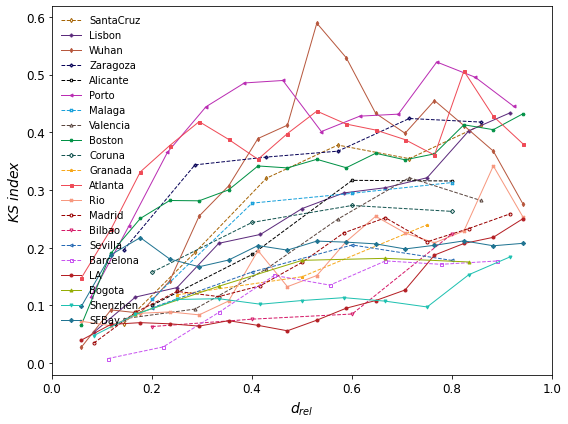

In [14]:
# sort cities by slope of ks index 
import operator
sorted_A2 = sorted(cityA2values.items(), key=operator.itemgetter(1))
sorted_A2 = sorted_A2[::-1]

sortedIdx = [cities.index(c[0]) for c in sorted_A2]
print(cities)
print("Sorted cities :")
print(sortedIdx)
cities = [c[0] for c in sorted_A2]
print(cities)

# plot
fig = plt.figure(figsize=(8,6))
for city in cities:
    X, Y = cityKSindex[city]
    # plt.plot(X, Y, linewidth=1.5, linestyle='-',\
    #      c=cityColors[city], label=city)
    if city in cities_spain:
        ls = "--"
    else:
        ls = "-"
    plt.plot(X[1:], Y[1:], marker=cityMarkers[city], markersize=3,
        markeredgecolor=cityColors[city], \
        markeredgewidth=1, markerfacecolor=cityFaceColors[city], \
        linestyle=ls, linewidth=1.0, c=cityColors[city], label=city)

# plt.xlim(0, 1)
# plt.ylim(0)
# plt.ylim(0.001)
# plt.yscale("log")
plt.xticks(np.linspace(0, 1.0 ,6), fontsize=12)
plt.yticks(fontsize=12)
# plt.xlabel(r'$d \ /\  d_{max}$', fontsize=14)
plt.xlabel(r'$d_{rel}$', fontsize=14)
plt.ylabel(r"$KS \ index$", fontsize=14)
plt.legend(frameon=False)
plt.tight_layout()
plt.show()
# plt.savefig(dataPath + 'results2022/KS_dist_woZero.png', dpi=200)
# plt.savefig(dataPath + 'results2022/KS_dist_woZero.pdf')
# plt.close()



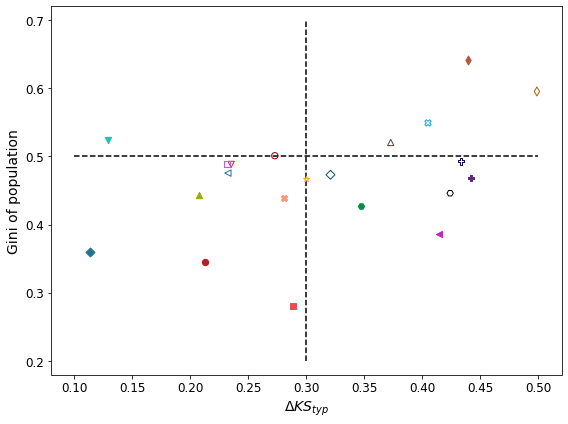

In [15]:
# plot Gini of population vs. A2 values
# plot cities separatly in subplots
fig = plt.figure(figsize=(8, 6))

X = [cityA2values[city] for city in cities]
Y = [cityInfo[city][3] for city in cities]  # Gini
# Y = [cityInfo[city][5] for city in cities]  # Crowding

# ax.scatter(X, Y, c=colors, s=30)
for i in range(len(cities)):
    city = cities[i]
    plt.scatter([X[i]], [Y[i]], s=40, facecolor=cityFaceColors[city], \
        marker=cityMarkers[city], edgecolor=cityColors[city], lw=1, label=city, zorder=2)
# ax.scatter(X, Y, s=30, c=colors, lw=2)
plt.plot([0.1, 0.5], [0.5, 0.5], lw=1.5, linestyle='--', c="k", zorder=1)
plt.plot([0.30, 0.30], [0.2, 0.7], lw=1.5, linestyle='--', c="k", zorder=1)

plt.xlim(0.08, 0.52)
plt.ylim(0.18, 0.72)
# plt.xticks(np.linspace(0, 1.0, 6), fontsize=16)
# plt.yticks(np.linspace(0, 2.0, 5), fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# plt.grid(linestyle="dotted")
# plt.xlabel(r"Slop of $KS$ index", fontsize=14)
plt.xlabel(r"$\Delta {KS}_{typ}$", fontsize=14)
plt.ylabel("Gini of population", fontsize=14)
# plt.legend(frameon=False)
plt.tight_layout()
plt.show()
# plt.savefig(dataPath + 'results2022/Gini_KSslope_woZero.png', dpi=200)
# plt.savefig(dataPath + 'results2022/Gini_KSslope_woZero.pdf')
# plt.close()

# change of KS index compared to shelter

Madrid 35
1.0 1.0223772990008069
1.0223772990008069 

Barcelona 35
1.0 1.0236021401344968
1.0236021401344968 

Valencia 35
1.0 1.0411228787226579
1.0411228787226579 

Alicante 35
1.0 1.0473314472997697
1.0473314472997697 

Coruna 35
1.0 1.0355892037339687
1.0355892037339687 

Zaragoza 35
1.0 1.0476704862351252
1.0476704862351252 

Sevilla 35
1.0 1.0251380153817269
1.0251380153817269 

Malaga 35
1.0 1.0219581457247637
1.0219581457247637 

Bilbao 35
1.0 1.0409586654207876
1.0409586654207876 

SantaCruz 35
1.0 1.05071243923645
1.05071243923645 

Granada 35
1.0 1.0218118719617737
1.0218118719617737 



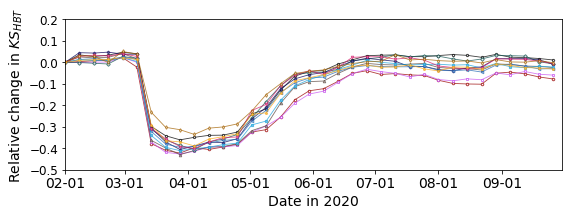

In [17]:

allDays, cities_KS_change, cities_KS_slope_change, _, cities_avgGyration_change = \
    pickle.load(open(dataPath + "results/cities_KS_change_woZero_2020.pkl", "rb"))

numFrames = len(allDays)

dates_x_str_ = ["2020-%s-01" % str(m).zfill(2) for m in range(2,10)]
dates_x_str = ["%s-01" % str(m).zfill(2) for m in range(2,10)]
dates_x = [allDays.index(d) for d in dates_x_str_]



# all cities in one
# plot change of KS by day
fig = plt.figure(figsize=(8, 3))
ax = plt.subplot(1, 1, 1)
# plot figures for annimation per city
for city in cities_spain:
    KS_change = cities_KS_change[city]
    deltaKS = cities_KS_slope_change[city]
    avgRgs = cities_avgGyration_change[city]

    # convert to weekly data
    numWeeks = len(allDays)//7 + 1
    Y_week = [np.nanmean(KS_change[7*w:7*w+7]) for w in range(numWeeks)]
    Y_week = [y/Y_week[0] for y in Y_week]
    
    maxChange = np.max(Y_week) / Y_week[0]
    print(city, len(Y_week))
    print(Y_week[0], np.max(Y_week))
    print(maxChange, "\n")

    Y_week = [y-1 for y in Y_week]
    # plt.plot(range(numFrames), KS_change, # marker="o",
    plt.plot(range(numFrames)[::7], Y_week, # marker="o", 
        marker=cityMarkers[city], markersize=2.5,
        markeredgecolor=cityColors[city], markeredgewidth=1, \
        markerfacecolor='#ffffff', linewidth=0.85, c=cityColors[city], \
        alpha=0.75, label=city)

    # plt.plot([42,42], [0.1, 1.0], lw=2, linestyle="--", c="k")
    # plt.plot([42,42], [0, 15], lw=2, linestyle="--", c="k")
    
# plot line every week
for d in range(numFrames):
    if d%7 != 0:
        continue
    # plt.plot([d,d], [0.3, 0.9], lw=0.3, linestyle="--", c="#666666")
    # plt.plot([d,d], [0.1, 1.0], lw=0.3, linestyle="--", c="#666666")
    # plt.plot([d,d], [0, 15], lw=0.3, linestyle="--", c="#666666")


plt.xlim(0, 242)
# plt.ylim(0.15, 1.05) # deltaKS
# plt.ylim(-0.5, 12.4) # avgRgs
# plt.ylim(0.001)
# plt.yscale("log")
# plt.ylim(-0.5, 1.5) # relative delta KS
# plt.ylim(-1, 1.5) # relative Rg
plt.ylim(-0.5, 0.2) # relative KS_HBT

plt.xticks(dates_x, dates_x_str, fontsize=14)

# plt.xticks(range(0, 92, 10), fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel(r'Date in 2020', fontsize=14)
# plt.ylabel(r"$KS_{HBT}$", fontsize=14)
# plt.ylabel(r"$\Delta {KS}$", fontsize=14)
# plt.ylabel(r"Average $R_g$ [km]", fontsize=14)
plt.ylabel(r"Relative change in $KS_{HBT}$", fontsize=14)
# plt.legend(loc="upper right", frameon=False, fontsize=12)

plt.tight_layout()
plt.show()
# plt.savefig(dataPath + 'results/secondWave/RelativeDeltaKS_2020_week' + '.pdf', dpi=200)
# plt.savefig(dataPath + 'results/secondWave/RelativeKS_HBT_2020_week' + '.pdf', dpi=200)
# plt.savefig(dataPath + 'results/secondWave/KS_slope_change_2020' + '.png', dpi=200)
# plt.savefig(dataPath + 'results/secondWave/KS_slope_change_2020' + '.pdf')
# plt.savefig(dataPath + 'results/secondWave/avgRg_change_2020' + '_Oct.pdf')

# plt.close()

# Gini and delta KS during COVID-19

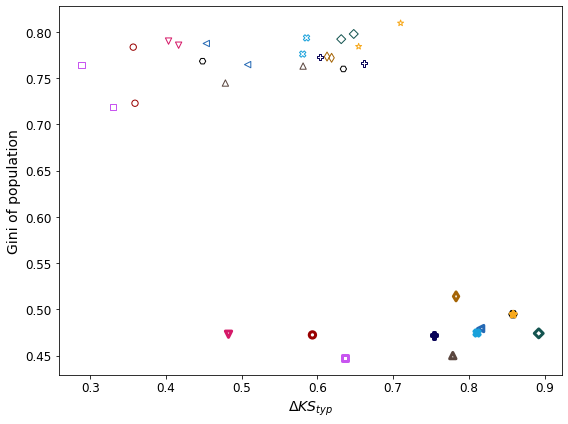

In [18]:
# convert to weekly data
numWeeks = len(allDays)//7 + 1
cities_KS_change_week = {}
cities_KS_slope_change_week = {}
for city in cities_spain:
    cities_KS_change_week[city] = [np.nanmean(cities_KS_change[city][7*w:7*w+7]) for w in range(numWeeks)]
    cities_KS_slope_change_week[city] = [np.nanmean(cities_KS_slope_change[city][7*w:7*w+7]) for w in range(numWeeks)]


# plot Gini of population vs. A2 values
# plot cities separatly in subplots
fig = plt.figure(figsize=(8, 6))

X1 = [cities_KS_slope_change_week[city][0] for city in cities_spain]  # normal
X2 = [cities_KS_slope_change_week[city][9] for city in cities_spain]  # first wave
X3 = [cities_KS_slope_change_week[city][-1] for city in cities_spain]  # recoverd

Y1 = [cities_KS_change_week[city][0] for city in cities_spain]  # normal
Y2 = [cities_KS_change_week[city][9] for city in cities_spain]  # first wave
Y3 = [cities_KS_change_week[city][-1] for city in cities_spain]  # recoverd


# ax.scatter(X, Y, c=colors, s=30)
for i in range(len(cities_spain)):
    city = cities_spain[i]
    plt.scatter([X1[i]], [Y1[i]], s=40, facecolor=cityFaceColors[city], \
        marker=cityMarkers[city], edgecolor=cityColors[city], lw=1, label=city, zorder=2)
    plt.scatter([X2[i]], [Y2[i]], s=40, facecolor=cityFaceColors[city], \
        marker=cityMarkers[city], edgecolor=cityColors[city], lw=3, label=city, zorder=2)
    plt.scatter([X3[i]], [Y3[i]], s=40, facecolor=cityFaceColors[city], \
        marker=cityMarkers[city], edgecolor=cityColors[city], lw=1, label=city, zorder=2)
# ax.scatter(X, Y, s=30, c=colors, lw=2)
# plt.plot([0.1, 0.5], [0.5, 0.5], lw=1.5, linestyle='--', c="k", zorder=1)
# plt.plot([0.30, 0.30], [0.2, 0.7], lw=1.5, linestyle='--', c="k", zorder=1)

# plt.xlim(0.08, 0.52)
# plt.ylim(0.18, 0.72)
# plt.xticks(np.linspace(0, 1.0, 6), fontsize=16)
# plt.yticks(np.linspace(0, 2.0, 5), fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# plt.grid(linestyle="dotted")
# plt.xlabel(r"Slop of $KS$ index", fontsize=14)
plt.xlabel(r"$\Delta {KS}_{typ}$", fontsize=14)
plt.ylabel("Gini of population", fontsize=14)
# plt.legend(frameon=False)
plt.tight_layout()
plt.show()
# plt.savefig(dataPath + 'results2022/Gini_KSslope_woZero.png', dpi=200)
# plt.savefig(dataPath + 'results2022/Gini_KSslope_woZero.pdf')
# plt.close()